# PC Yearly Automatization

## Imports and Functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy as sp
import os
from itertools import combinations

import sys
import seaborn as sns
import re
import pickle


import cartopy.crs as ccrs
import cartopy.feature as cfeature



In [2]:
# Add the folder to the Python path

os.chdir("../")
# change working directory to project's root path
print(os.getcwd())

folder_path = os.path.abspath("functions/") #INPUT_PATH)#'path_to_your_folder')  # Replace with the actual folder path
sys.path.insert(0, folder_path)

c:\Users\marti\Desktop\data\hw_extra


In [3]:

from IndexDrivers import (
    MultivariatePCA, 
    plot_hw_index,
    plot_hw_index_by_season,
    scatter_color_year,
    scatter_color_season
)

In [4]:
def df_to_series(dataframe, name_series, years=[1979,2023]):
    selected = dataframe[(dataframe["Year"]< years[1]) & (dataframe["Year"] > years[0])]
    df_melted = selected.melt(id_vars=['Year'], var_name='Month', value_name=name_series)
    df_melted["Month"] = pd.to_numeric(df_melted["Month"])
    df_melted = df_melted.sort_values(['Year','Month'])

    df_melted['Date'] = pd.to_datetime(df_melted[['Year', 'Month']].assign(DAY=1))
    df_melted.set_index('Date', inplace=True)

    return df_melted.drop(columns=["Year", "Month"])

def plot_corr(dataframe, cols):
    sns.heatmap(dataframe.corr()[cols], cmap="coolwarm", annot=True)
    plt.show()

def compute_correlations(df, num_indices=5, method='pearson'):
    """
    Compute the correlation between the first `num_indices` columns and the rest of the columns in a DataFrame
    using the specified method (Pearson, Spearman, or Kendall).
    
    Parameters:
    - df: pd.DataFrame, the input DataFrame with timeseries as columns.
    - num_indices: int, number of columns to use as the principal indices for correlation.
    - method: str, the method for correlation ('pearson', 'spearman', 'kendall').
    
    Returns:
    - pd.DataFrame with correlations between the `num_indices` columns and the rest of the columns.
    """
    if method not in ['pearson', 'spearman', 'kendall']:
        raise ValueError("Method must be 'pearson', 'spearman', or 'kendall'")

    # Extract the first `num_indices` columns as principal indices
    principal_df = df.iloc[:, :num_indices]
    
    # Extract the rest of the columns
    other_df = df.iloc[:, num_indices:]
    
    # If method is not 'pearson', we need to use rank correlation methods
    if method == 'spearman':
        # Rank the data for Spearman correlation
        principal_df = principal_df.rank()
        other_df = other_df.rank()
    elif method == 'kendall':
        # Pandas `.corr()` will be used for Kendall to handle pairwise calculation
        return other_df.corrwith(principal_df, axis=0, method='kendall')
    
    # Compute correlation matrix using dot product for Pearson or Spearman
    principal_values = principal_df.values
    other_values = other_df.values
    
    # Mean-center the data
    principal_mean_centered = principal_values - principal_values.mean(axis=0)
    other_mean_centered = other_values - other_values.mean(axis=0)
    
    # Compute the standard deviations
    principal_std = principal_values.std(axis=0)
    other_std = other_values.std(axis=0)
    
    # Normalize data
    principal_normalized = principal_mean_centered / principal_std
    other_normalized = other_mean_centered / other_std
    
    # Compute the correlation matrix using dot product
    correlations = np.dot(other_normalized.T, principal_normalized) / (other_values.shape[0] - 1)
    
    # Convert to DataFrame for readability, using original column names
    correlation_df = pd.DataFrame(
        correlations,
        columns=df.columns[:num_indices],  # Names of the principal indices columns
        index=df.columns[num_indices:]     # Names of the remaining columns
    )
    
    return correlation_df


In [5]:
ds_6means = xr.load_dataset("data/local_data/6means_world.nc")
generate_pcas = False

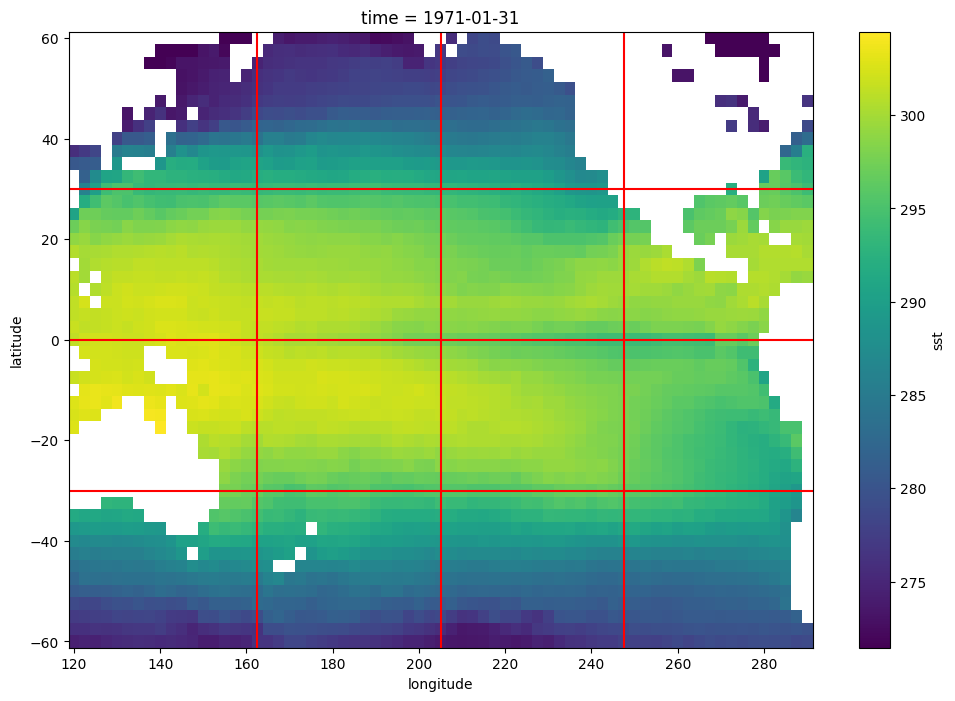

In [6]:
boxes1 = {
    0: [120,205,30,60],
    1: [205,290,30,60],
    2: [120,205,0,30],
    3: [205,290,0,30],
    4: [120,205,-30,0],
    5: [205,290,-30,0],
    6: [120,205,-60,-30],
    7: [205,290,-60,-30]
}
# New dictionary to hold 16 sub-boxes
boxes2 = {}

# Counter for keys in boxes2
new_key = 0

# Iteratively split each box into two
for key, (lon_min, lon_max, lat_min, lat_max) in boxes1.items():
    # Calculate the longitude midpoint
    lon_mid = (lon_min + lon_max) / 2
    
    # Define two new sub-boxes by splitting along the longitude midpoint
    boxes2[new_key] = [lon_min, lon_mid, lat_min, lat_max]
    new_key += 1
    boxes2[new_key] = [lon_mid, lon_max, lat_min, lat_max]
    new_key += 1

fig, axs = plt.subplots(figsize=(12,8))
ds_6means.sel(latitude=slice(-60,60), longitude=slice(120,290)).sst.isel(time=0).plot(ax=axs)
for i in range(3):
    axs.axhline(-30+i*30, c="red")
axs.axvline(205, c="red")
axs.axvline(162.5, c="red")
axs.axvline(247.5, c="red")
plt.show()

In [7]:
if generate_pcas:
    variables = ["SST", "SP", "TTR", "U10", "V10", "Z"]
    var_combi = []

    for r in range(1, len(variables) + 1):
        var_combi.extend(combinations(variables, r))

    # Iterate over each box and each combination of variables
    k = 0
    pcas = {}
    for box_id, box_coords in boxes2.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_6means, 3, [1972,2022], box_limit=box_coords, variables=var_combination, frequency="yearly")

            k +=1

    for box_id, box_coords in boxes1.items():
        for var_combination in var_combi:
            pcas[k] = MultivariatePCA(ds_6means, 3, [1972,2022], box_limit=box_coords, variables=var_combination, frequency="yearly")

            k +=1
    with open("pcas_1972_yearly.pkl", "wb") as inp:
        pickle.dump(pcas, inp, protocol=pickle.HIGHEST_PROTOCOL)
else:
    with open("pcas_1972_yearly.pkl", 'rb') as inp:
        pcas = pickle.load(inp)

In [8]:
hwis_chile= pd.read_csv(f"data/local_data/yearly/HWs_chile_central.csv")
hwis_chile["Date"] = pd.to_datetime(hwis_chile["Date"],format='%Y')
hwis_chile.set_index('Date', inplace=True)
hwis_cali= pd.read_csv(f"data/local_data/yearly/HWs_california_NOAA.csv")
hwis_cali["Date"] = pd.to_datetime(hwis_cali["Date"],format='%Y')
hwis_cali.set_index('Date', inplace=True)


## Chile

In [9]:
first_year = 1972
hwis_chile = hwis_chile[(hwis_chile.index.year <= 2022) & (hwis_chile.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_12000\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12000\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_chile[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12000\3541934485.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually th

In [10]:
corr_chile = hwis_chile.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_chile.describe()

HWN          HWF          HWD          HWM          HWA
count  4536.000000  4536.000000  4536.000000  4536.000000  4536.000000
mean      0.002162    -0.007259    -0.006751     0.000896    -0.000809
std       0.113907     0.121877     0.137424     0.086629     0.110884
min      -0.351691    -0.346255    -0.350147    -0.332345    -0.350457
25%      -0.075386    -0.091302    -0.110006    -0.051796    -0.069193
50%       0.024384    -0.002471    -0.003101    -0.010666    -0.015780
75%       0.073298     0.076184     0.083254     0.065534     0.084991
max       0.294291     0.309518     0.371516     0.332550     0.342907

In [11]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

correlations = {
"pearson": compute_correlations(hwis_chile),
"spearman": compute_correlations(hwis_chile, method='spearman')
}
# Initialize dictionaries to hold positive and negative correlations
strong_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
any_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
# Iterate over each correlation matrix and collect pairs
for method, corr_df in correlations.items():
    for timeserie, row in corr_df.iterrows():
        for index, value in row.items():
            if value > 0.5:
                strong_correlations["positive"][method].append((timeserie, index, value))
            elif value < -0.5:
                strong_correlations["negative"][method].append((timeserie, index, value))
            if value >= 0:
                any_correlations["positive"][method].append((timeserie, index, value))
            elif value < 0:
                any_correlations["negative"][method].append((timeserie, index, value))
# Convert to DataFrames for easy viewing and saving
positive_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["positive"].items()
}
negative_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["negative"].items()
}
positive_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["positive"].items()
}
negative_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["negative"].items()
}
correlations_chile = [positive_corr_df, negative_corr_df]
any_corr_chile = [positive_corr_any_df, negative_corr_any_df]

In [12]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

for method in ["pearson", "spearman"]:
    if method in any_corr_chile[0]:
        for _, row in any_corr_chile[0][method].iterrows():
            all_correlations.append((method, *row))
    
    if method in any_corr_chile[1]:
        for _, row in any_corr_chile[1][method].iterrows():
            all_correlations.append(( method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_chile = pd.DataFrame(
    all_correlations, columns=["Method", "PC", "Index", "Correlation"]
)
all_correlations_df_chile['ID'] = all_correlations_df_chile['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_chile['Variance'] = all_correlations_df_chile.apply(lambda x: pcas[int(x.ID)].explained_variance[int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_chile.reindex(
    all_correlations_df_chile["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

         Method              PC Index  Correlation    ID  Variance
8157    pearson   PC_206-Mode-3   HWD     0.378946   206  0.115832
3902    pearson   PC_194-Mode-2   HWD     0.378728   194  0.334068
8136    pearson   PC_199-Mode-3   HWD     0.378325   199  0.139272
8202    pearson   PC_227-Mode-3   HWD     0.360893   227  0.100644
21359   pearson  PC_1003-Mode-3   HWN    -0.358724  1003  0.151337
...         ...             ...   ...          ...   ...       ...
21286   pearson   PC_987-Mode-3   HWN    -0.332443   987  0.118655
19260   pearson   PC_218-Mode-3   HWA    -0.332383   218  0.114868
29422  spearman   PC_242-Mode-3   HWA     0.332308   242  0.093292
21988   pearson  PC_1262-Mode-3   HWA    -0.332000  1262  0.000212
29417  spearman   PC_241-Mode-3   HWA     0.331938   241  0.105271

[100 rows x 6 columns]


In [13]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1}")

Highest correlation is PC_206 is on Box [247.5, 290, 30, 60] with variables ['TTR', 'Z'] on mode 3


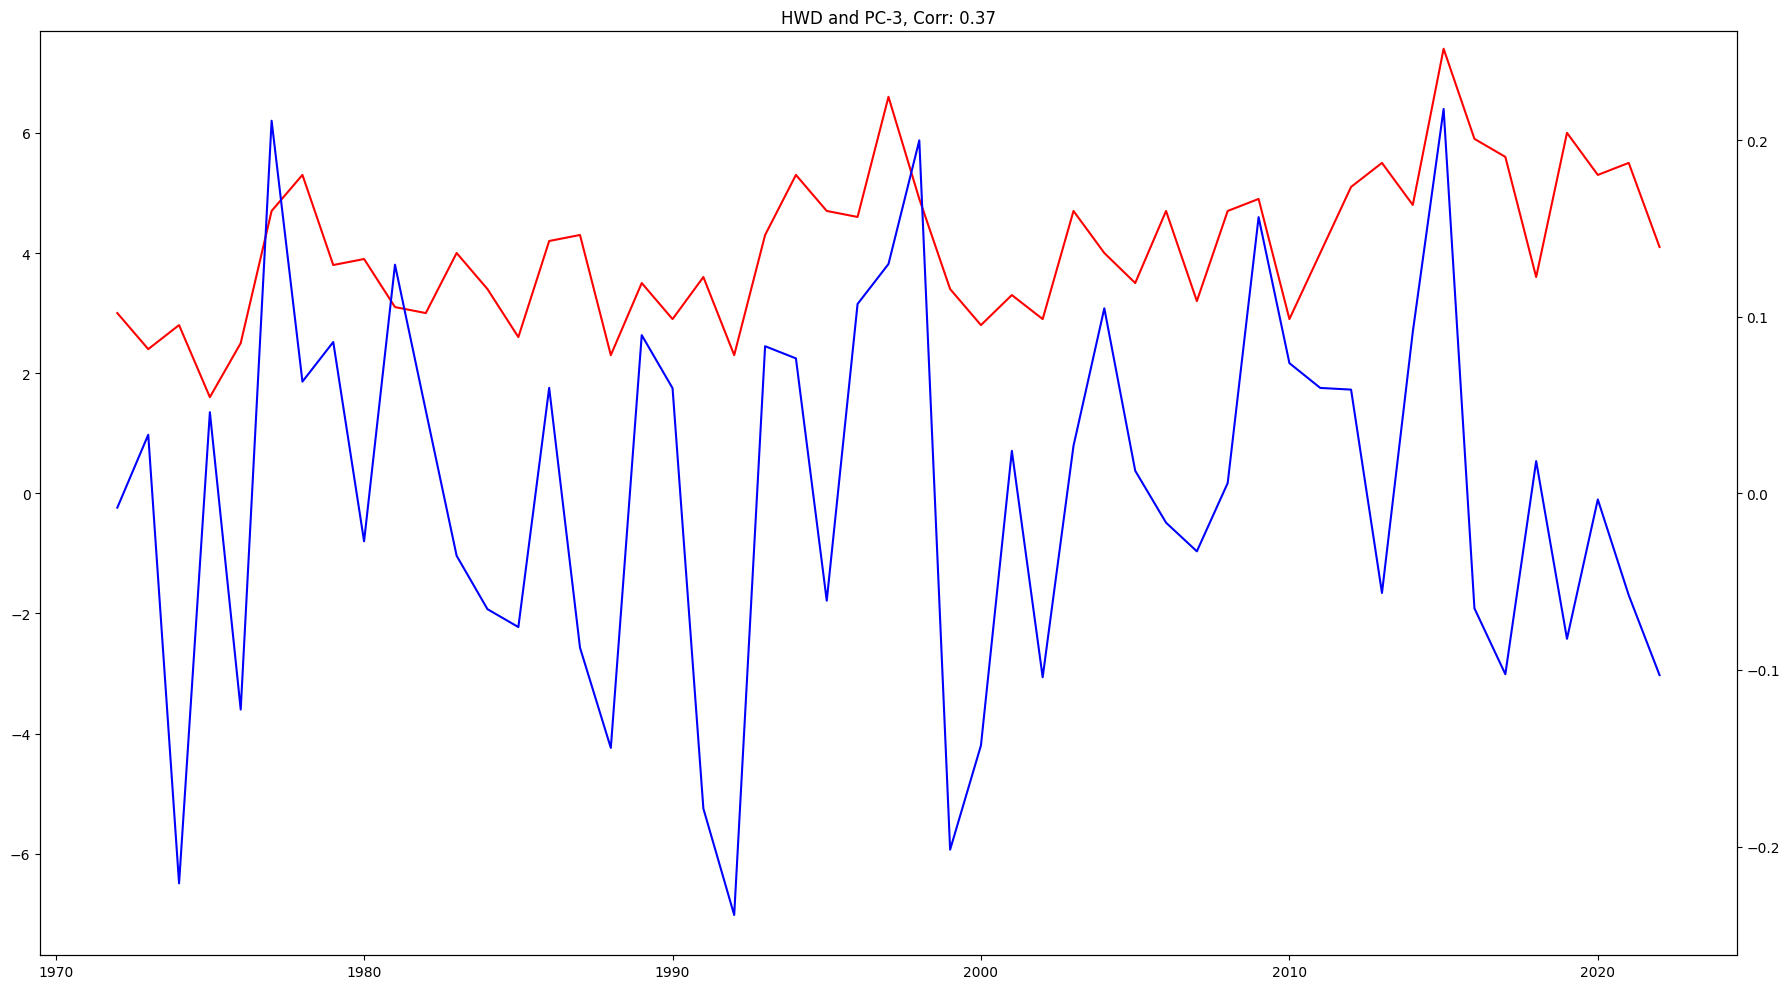

In [14]:
plot_hw_index(hwis_chile, ["HWD"], pcas[top1], mode_top1, start=first_year)

### Save top 20

In [15]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==10:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_206-Mode-3',
 'PC_194-Mode-2',
 'PC_199-Mode-3',
 'PC_227-Mode-3',
 'PC_1003-Mode-3',
 'PC_962-Mode-2',
 'PC_208-Mode-2',
 'PC_969-Mode-2',
 'PC_242-Mode-3',
 'PC_994-Mode-3']

In [16]:
hws_top20 = hwis_chile[indices_of_interest + top20_list]
hws_top20.to_csv(f"data/features/chile/from1972/top10/HWs_chile_features_yearly.csv")

## Save top 20 but filtering low variance

In [17]:
top_correlations = top_correlations[top_correlations["Variance"] >= 0.15]
top_correlations

Method              PC Index  Correlation    ID  Variance
3902    pearson   PC_194-Mode-2   HWD     0.378728   194  0.334068
21359   pearson  PC_1003-Mode-3   HWN    -0.358724  1003  0.151337
15889   pearson   PC_208-Mode-2   HWA    -0.357466   208  0.189712
17514   pearson   PC_969-Mode-2   HWN    -0.357359   969  0.228863
15887   pearson   PC_208-Mode-2   HWD    -0.357150   208  0.189712
17515   pearson   PC_969-Mode-2   HWF    -0.353180   969  0.228863
40272  spearman   PC_969-Mode-2   HWN    -0.352930   969  0.228863
38739  spearman   PC_225-Mode-2   HWM    -0.351600   225  0.157357
15892   pearson   PC_209-Mode-2   HWD    -0.350826   209  0.191944
17474   pearson   PC_959-Mode-2   HWN    -0.350649   959  0.312866
17475   pearson   PC_959-Mode-2   HWF    -0.350097   959  0.312866
25046  spearman   PC_203-Mode-2   HWA     0.350031   203  0.209926
21336   pearson   PC_998-Mode-3   HWN    -0.349378   998  0.174069
17587   pearson   PC_991-Mode-2   HWF    -0.346789   991  0.216384
21163   pearson   PC_955-Mode-3   HWF    -0.346621   955  0.196433
21360   pearson  PC_1003-Mode-3   HWF    -0.345800  1003  0.151337
40273  spearman   PC_969-Mode-2   HWF    -0.345739   969  0.228863
17561   pearson   PC_981-Mode-2   HWF    -0.345213   981  0.269883
31530  spearman  PC_1101-Mode-3   HWF     0.344908  1101  0.150546
25029  spearman   PC_194-Mode-2   HWM     0.344492   194  0.334068
17449   pearson   PC_950-Mode-2   HWF    -0.343639   950  0.338763
25028  spearman   PC_194-Mode-2   HWD     0.343195   194  0.334068
40208  spearman   PC_950-Mode-2   HWN    -0.343002   950  0.338763
40232  spearman   PC_959-Mode-2   HWN    -0.342771   959  0.312866
21162   pearson   PC_955-Mode-3   HWN    -0.342525   955  0.196433
17586   pearson   PC_991-Mode-2   HWN    -0.342502   991  0.216384
17448   pearson   PC_950-Mode-2   HWN    -0.341585   950  0.338763
17560   pearson   PC_981-Mode-2   HWN    -0.341176   981  0.269883
40344  spearman   PC_991-Mode-2   HWN    -0.340970   991  0.216384
15888   pearson   PC_208-Mode-2   HWM    -0.338992   208  0.189712
21253   pearson   PC_978-Mode-3   HWF    -0.338919   978  0.174693
40318  spearman   PC_981-Mode-2   HWN    -0.338846   981  0.269883
25045  spearman   PC_203-Mode-2   HWM     0.338769   203  0.209926
17494   pearson   PC_965-Mode-2   HWN    -0.338147   965  0.264855
17495   pearson   PC_965-Mode-2   HWF    -0.337959   965  0.264855
17635   pearson  PC_1004-Mode-2   HWN    -0.337335  1004  0.214509
40233  spearman   PC_959-Mode-2   HWF    -0.336877   959  0.312866
40345  spearman   PC_991-Mode-2   HWF    -0.336692   991  0.216384
25110  spearman   PC_224-Mode-2   HWA     0.335815   224  0.177047
17610   pearson   PC_999-Mode-2   HWN    -0.335414   999  0.254691
17539   pearson   PC_975-Mode-2   HWF    -0.335402   975  0.194072
17951   pearson  PC_1147-Mode-2   HWD    -0.335246  1147  0.217555
44067  spearman  PC_1003-Mode-3   HWN    -0.335151  1003  0.151337
40319  spearman   PC_981-Mode-2   HWF    -0.334153   981  0.269883
17538   pearson   PC_975-Mode-2   HWN    -0.333786   975  0.194072
21252   pearson   PC_978-Mode-3   HWN    -0.333318   978  0.174693
17581   pearson   PC_990-Mode-2   HWN    -0.333302   990  0.225989
18009   pearson  PC_1170-Mode-2   HWD    -0.333180  1170  0.181304

In [18]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==10:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_194-Mode-2',
 'PC_1003-Mode-3',
 'PC_208-Mode-2',
 'PC_969-Mode-2',
 'PC_225-Mode-2',
 'PC_209-Mode-2',
 'PC_959-Mode-2',
 'PC_203-Mode-2',
 'PC_998-Mode-3',
 'PC_991-Mode-2']

In [19]:
hws_top20 = hwis_chile[indices_of_interest+ top20_list]
hws_top20.to_csv(f"data/features/chile/from1972removing/top10/HWs_chile_features_yearly_removing.csv")

## California

In [20]:
first_year = 1972
hwis_cali = hwis_cali[(hwis_cali.index.year <= 2022) & (hwis_cali.index.year >= first_year)]

for mode in range(pcas[0].n_modes):
    for num, pca in pcas.items():
        hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)

C:\Users\marti\AppData\Local\Temp\ipykernel_12000\1042097159.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12000\1042097159.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  hwis_cali[f"PC_{num}-Mode-{mode+1}"] = pca.get_index(mode+1, start_year=first_year)
C:\Users\marti\AppData\Local\Temp\ipykernel_12000\1042097159.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the 

In [21]:
corr_cali = hwis_cali.corr()[["HWN", "HWF", "HWD", "HWM", "HWA"]][5:]
corr_cali.describe()

HWN          HWF          HWD          HWM          HWA
count  4536.000000  4536.000000  4536.000000  4536.000000  4536.000000
mean     -0.016621    -0.016719    -0.010939    -0.008589    -0.011879
std       0.099071     0.114045     0.137207     0.091349     0.102559
min      -0.397086    -0.471425    -0.427984    -0.316599    -0.364665
25%      -0.062873    -0.090167    -0.111797    -0.078348    -0.097920
50%      -0.014698    -0.022972    -0.041510    -0.011862    -0.009966
75%       0.037206     0.060112     0.099000     0.056355     0.062228
max       0.353982     0.384556     0.368753     0.348921     0.347066

In [22]:
indices_of_interest = ["HWN", "HWF", "HWD", "HWM", "HWA"]

correlations = {
"pearson": compute_correlations(hwis_cali),
"spearman": compute_correlations(hwis_cali, method='spearman')
}
# Initialize dictionaries to hold positive and negative correlations
strong_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
any_correlations = {
    "positive": {"pearson": [], "spearman": []},
    "negative": {"pearson": [], "spearman": []}
}
# Iterate over each correlation matrix and collect pairs
for method, corr_df in correlations.items():
    for timeserie, row in corr_df.iterrows():
        for index, value in row.items():
            if value > 0.5:
                strong_correlations["positive"][method].append((timeserie, index, value))
            elif value < -0.5:
                strong_correlations["negative"][method].append((timeserie, index, value))
            if value >= 0:
                any_correlations["positive"][method].append((timeserie, index, value))
            elif value < 0:
                any_correlations["negative"][method].append((timeserie, index, value))
# Convert to DataFrames for easy viewing and saving
positive_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["positive"].items()
}
negative_corr_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in strong_correlations["negative"].items()
}
positive_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["positive"].items()
}
negative_corr_any_df = {
    method: pd.DataFrame(pairs, columns=["Timeserie", "Index", "Correlation"])
    for method, pairs in any_correlations["negative"].items()
}
correlations_chile = [positive_corr_df, negative_corr_df]
any_corr_chile = [positive_corr_any_df, negative_corr_any_df]

In [23]:
# Initialize a list to collect all correlations from all months and methods
all_correlations = []

for method in ["pearson", "spearman"]:
    if method in any_corr_chile[0]:
        for _, row in any_corr_chile[0][method].iterrows():
            all_correlations.append((method, *row))
    
    if method in any_corr_chile[1]:
        for _, row in any_corr_chile[1][method].iterrows():
            all_correlations.append(( method, *row))

# Convert the collected data to a DataFrame for easier processing
all_correlations_df_cali = pd.DataFrame(
    all_correlations, columns=["Method", "PC", "Index", "Correlation"]
)
all_correlations_df_cali['ID'] = all_correlations_df_cali['PC'].apply(lambda x: re.search(r'PC_(.*?)-Mode-', x).group(1))
# Sort by the absolute value of the correlation and get the top 10

## Include explained variance
all_correlations_df_cali['Variance'] = all_correlations_df_cali.apply(lambda x: pcas[int(x.ID)].explained_variance[int(x.PC[-1])-1], axis=1)


top_correlations = all_correlations_df_cali.reindex(
    all_correlations_df_cali["Correlation"].abs().sort_values(ascending=False).index
).head(100)

# Display the top 10 correlations
print(top_correlations)

         Method              PC Index  Correlation    ID  Variance
40253  spearman   PC_964-Mode-2   HWF    -0.555315   964  0.252543
40291  spearman   PC_974-Mode-2   HWF    -0.553607   974  0.192999
44025  spearman   PC_993-Mode-3   HWF    -0.552868   993  0.123020
40359  spearman   PC_995-Mode-2   HWF    -0.511373   995  0.183976
44083  spearman  PC_1005-Mode-3   HWF    -0.509988  1005  0.128316
...         ...             ...   ...          ...   ...       ...
21594   pearson  PC_1084-Mode-3   HWF    -0.407152  1084  0.153557
44062  spearman  PC_1001-Mode-3   HWN    -0.406846  1001  0.127523
44067  spearman  PC_1002-Mode-3   HWN    -0.406476  1002  0.152443
27867  spearman   PC_988-Mode-2   HWF     0.405997   988  0.159925
40263  spearman   PC_966-Mode-2   HWF    -0.405674   966  0.142261

[100 rows x 6 columns]


In [24]:
top1 = int(list(top_correlations["ID"])[0])
mode_top1 = int(list(top_correlations["PC"])[0][-1])
print(f"Highest correlation is PC_{top1} is on Box {pcas[top1].box} with variables {list(pcas[top1].variables_dict.values())} on mode {mode_top1}")

Highest correlation is PC_964 is on Box [247.5, 290, -60, -30] with variables ['U10', 'Z'] on mode 2


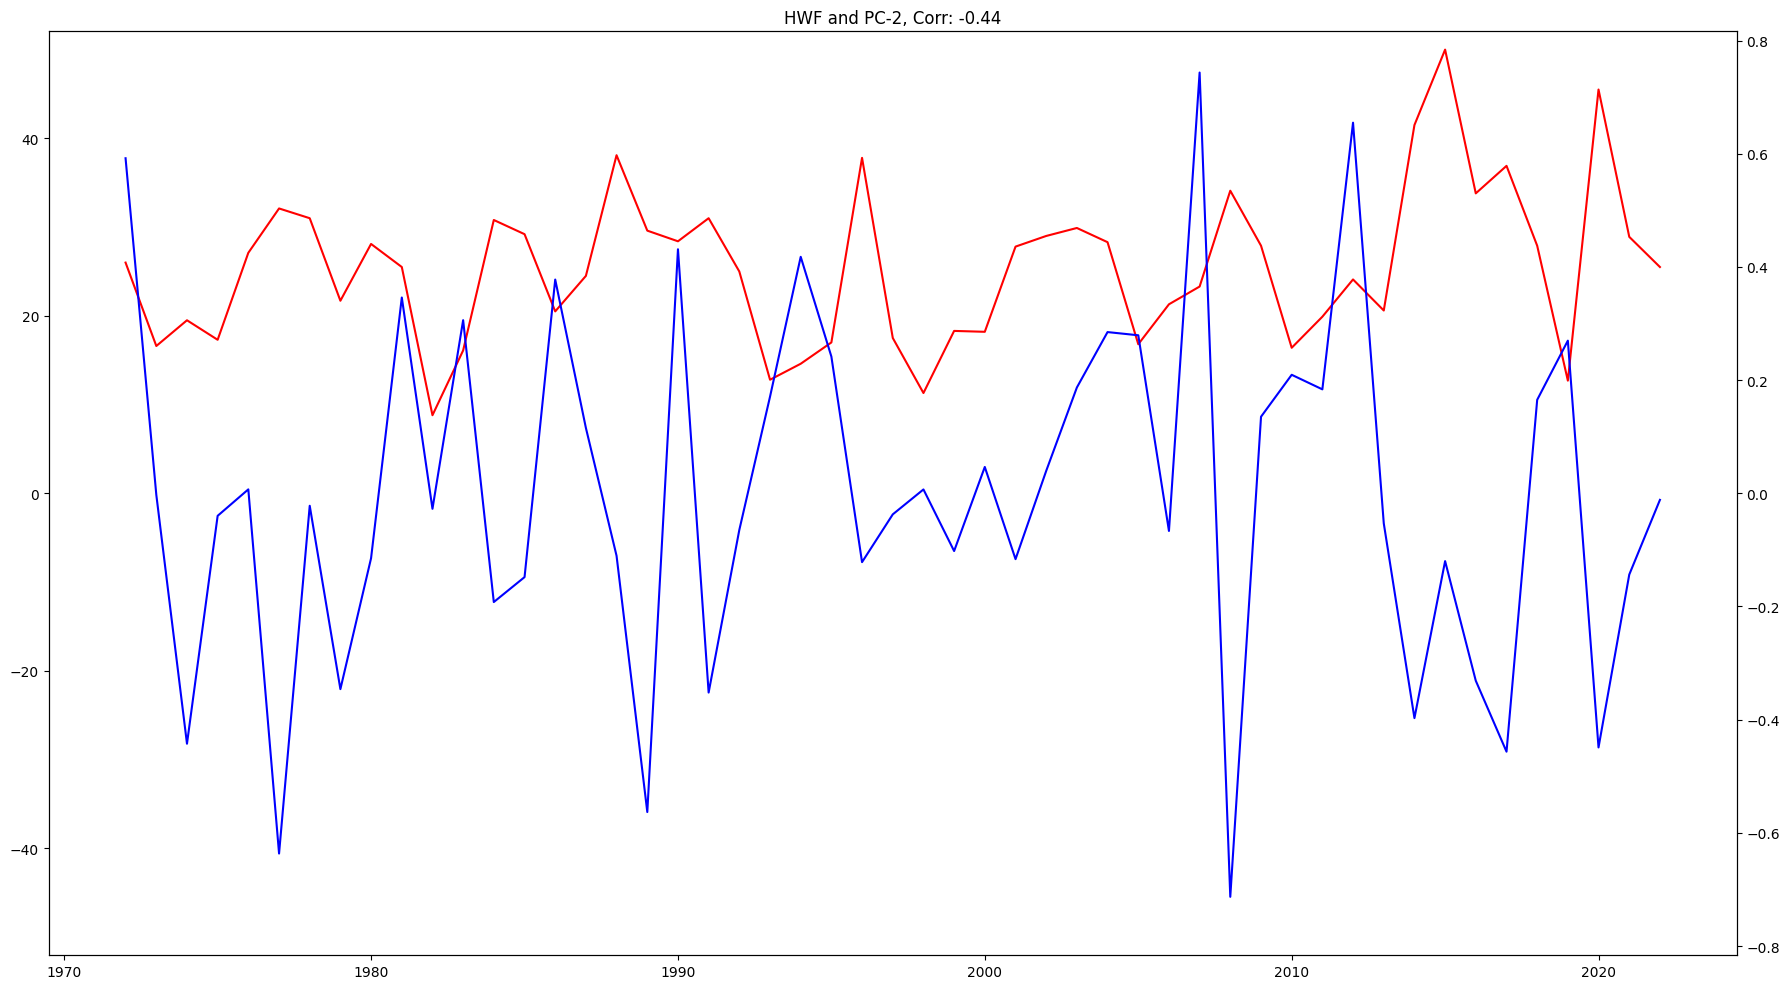

In [25]:
plot_hw_index(hwis_cali, ["HWF"], pcas[top1], mode_top1, start=first_year)

### Save top 20

In [26]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==10:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_964-Mode-2',
 'PC_974-Mode-2',
 'PC_993-Mode-3',
 'PC_995-Mode-2',
 'PC_1005-Mode-3',
 'PC_983-Mode-3',
 'PC_986-Mode-3',
 'PC_962-Mode-2',
 'PC_990-Mode-2',
 'PC_1002-Mode-3']

In [27]:
hws_top20 = hwis_cali[indices_of_interest + top20_list]
hws_top20.to_csv("data/features/california/from1972/top10/HWs_cali_features_yearly.csv")

## Save top 20 but filtering low variance ones

In [28]:
top_correlations = top_correlations[top_correlations["Variance"] >= 0.15]
top_correlations

Method              PC Index  Correlation    ID  Variance
40253  spearman   PC_964-Mode-2   HWF    -0.555315   964  0.252543
40291  spearman   PC_974-Mode-2   HWF    -0.553607   974  0.192999
40359  spearman   PC_995-Mode-2   HWF    -0.511373   995  0.183976
40346  spearman   PC_990-Mode-2   HWF    -0.494803   990  0.225989
44068  spearman  PC_1002-Mode-3   HWF    -0.494295  1002  0.152443
40328  spearman   PC_985-Mode-2   HWF    -0.493280   985  0.228636
41334  spearman  PC_1454-Mode-2   HWF    -0.486772  1454  0.217583
40268  spearman   PC_967-Mode-2   HWF    -0.486310   967  0.198988
44093  spearman  PC_1007-Mode-3   HWF    -0.481463  1007  0.151752
40314  spearman   PC_980-Mode-2   HWF    -0.474771   980  0.282664
36198  spearman   PC_950-Mode-1   HWF    -0.470617   950  0.366542
44045  spearman   PC_997-Mode-3   HWF    -0.469832   997  0.172535
17576   pearson   PC_974-Mode-2   HWF    -0.465984   974  0.192999
40252  spearman   PC_964-Mode-2   HWN    -0.465817   964  0.252543
40197  spearman   PC_948-Mode-2   HWF    -0.460831   948  0.255209
40224  spearman   PC_957-Mode-2   HWF    -0.459585   957  0.269188
40398  spearman  PC_1004-Mode-2   HWF    -0.458339  1004  0.214509
17539   pearson   PC_964-Mode-2   HWF    -0.451806   964  0.252543
44088  spearman  PC_1006-Mode-3   HWF    -0.450723  1006  0.167963
40248  spearman   PC_963-Mode-2   HWF    -0.448507   963  0.185467
40376  spearman   PC_999-Mode-2   HWF    -0.444769   999  0.254691
17640   pearson   PC_995-Mode-2   HWF    -0.443123   995  0.183976
40341  spearman   PC_989-Mode-2   HWF    -0.440938   989  0.188288
41351  spearman  PC_1463-Mode-2   HWF    -0.433553  1463  0.218560
40290  spearman   PC_974-Mode-2   HWN    -0.431182   974  0.192999
18659   pearson  PC_1454-Mode-2   HWF    -0.430771  1454  0.217583
40309  spearman   PC_979-Mode-2   HWF    -0.430552   979  0.235005
40358  spearman   PC_995-Mode-2   HWN    -0.429012   995  0.183976
17630   pearson   PC_990-Mode-2   HWF    -0.426341   990  0.225989
40345  spearman   PC_990-Mode-2   HWN    -0.424763   990  0.225989
41422  spearman  PC_1508-Mode-2   HWF    -0.424506  1508  0.151319
44073  spearman  PC_1003-Mode-3   HWF    -0.422798  1003  0.151337
17612   pearson   PC_985-Mode-2   HWF    -0.422214   985  0.228636
44274  spearman  PC_1084-Mode-3   HWF    -0.421644  1084  0.153557
17553   pearson   PC_967-Mode-2   HWF    -0.419725   967  0.198988
40327  spearman   PC_985-Mode-2   HWN    -0.418668   985  0.228636
41883  spearman   PC_162-Mode-3   HWF    -0.416936   162  0.160996
27813  spearman   PC_951-Mode-2   HWF     0.414120   951  0.267311
41415  spearman  PC_1503-Mode-2   HWF    -0.412828  1503  0.181436
40313  spearman   PC_980-Mode-2   HWN    -0.412664   980  0.282664
21386   pearson  PC_1002-Mode-3   HWF    -0.412312  1002  0.152443
41386  spearman  PC_1484-Mode-2   HWF    -0.411766  1484  0.184838
17598   pearson   PC_980-Mode-2   HWF    -0.411008   980  0.282664
38585  spearman   PC_192-Mode-2   HWD    -0.408712   192  0.180265
15810   pearson   PC_192-Mode-2   HWD    -0.408215   192  0.180265
44050  spearman   PC_998-Mode-3   HWF    -0.408028   998  0.174069
40267  spearman   PC_967-Mode-2   HWN    -0.407954   967  0.198988
21594   pearson  PC_1084-Mode-3   HWF    -0.407152  1084  0.153557
44067  spearman  PC_1002-Mode-3   HWN    -0.406476  1002  0.152443
27867  spearman   PC_988-Mode-2   HWF     0.405997   988  0.159925

In [29]:
top20_list = []
for pc in list(top_correlations["PC"]):
    if len(top20_list)==10:
        break
    elif pc not in top20_list:
        top20_list.append(pc)

top20_list

['PC_964-Mode-2',
 'PC_974-Mode-2',
 'PC_995-Mode-2',
 'PC_990-Mode-2',
 'PC_1002-Mode-3',
 'PC_985-Mode-2',
 'PC_1454-Mode-2',
 'PC_967-Mode-2',
 'PC_1007-Mode-3',
 'PC_980-Mode-2']

In [30]:
hws_top20 = hwis_cali[indices_of_interest + top20_list]
hws_top20.to_csv("data/features/california/from1972removing/top10/HWs_cali_features_yearly_removing.csv")